# Solve 2D Laplace's equation 

## Import packages

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

from neal import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite, DWaveSampler

from dwaveutils import bl_lstsq
from dwaveutils.utils import Binary2Float

## Define function

In [2]:
def get_laplace_2D(N, delta, BC, num_bits, fixed_point=0):
    """Get information about 2D Laplace's equation (steady-state heat equation)."""

    # Get finite-difference stiffness matrix
    Ax = sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(N['x'], N['x'])) / (delta['x'] ** 2)
    Ay = sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(N['y'], N['y'])) / (delta['y'] ** 2)
    Ix = sparse.identity(N['x'])
    Iy = sparse.identity(N['y'])
    A = (sparse.kron(Iy, Ax) + sparse.kron(Ay, Ix)).tocsc()

    # Get RHS
    b = np.zeros((N['y'], N['x']))
    # boundary conditions
    b[-1, :] = b[-1, :] + BC['top'] / (delta['y'] ** 2)
    b[0, :] = b[0, :] + BC['bottom'] / (delta['y'] ** 2)
    b[:, 0] = b[:, 0] + BC['left'] / (delta['x'] ** 2)
    b[:, -1] = b[:, -1] + BC['right'] / (delta['x'] ** 2)
    b = sparse.csr_matrix(b.reshape(N['x']*N['y'], 1))

    # set the bit value to discrete the actual value as a fixed point
    bit_value = bl_lstsq.get_bit_value(num_bits, fixed_point=fixed_point)
    # discretized version of matrix `A`
    A_discrete = bl_lstsq.discretize_matrix(A.toarray(), bit_value)

    output = {
        'A': A,
        'b': b,
        'A_discrete': A_discrete,
        'bit_value': bit_value
    }
    return output


def get_temperature(x, N, BC):
    # Get temperature T
    T = np.zeros((N['y']+2, N['x']+2))
    T[1:N['y']+1, 1:N['x']+1] = x.reshape(N['y'], N['x'])
    T[-1, 1:N['x']+1] = BC['top']
    T[0, 1:N['x']+1] = BC['bottom']
    T[1:N['y']+1, 0] = BC['left']
    T[1:N['y']+1, -1] = BC['right']

    return T

## Setting variables

In [3]:
# Length along different axis
L = {
    'x': 1,
    'y': 1.5
}
# Number of **interior** points
N = {
    'x': 3,
    'y': 5
}
# The distance between two adjacent points
delta = {
    'x': L['x'] / (N['x'] + 1),
    'y': L['y'] / (N['y'] + 1)
}
# Boundary conditions (only implement Dirichlet conditions)
BC = {
    'top': 100,
    'bottom': 0,
    'left': 0, 
    'right': 0
}
# number of bits (include sign bit)
num_bits = 6
# n-vector bit value is defined by
# [-2**(fixed_point), 2**(fixed_point-1), ..., 2**(fixed_point-n)]
fixed_point = 6
# scaling factor for QUBO
eq_scaling_val = 1/8
# number of reads for Simulated annealing (SA) or Quantum annealing (QA)
num_reads = 1000
# sampler type must be one of {'SA', 'QA'}
sampler_type = 'SA'

# setup A, b, A_discrete, bit_value
output = get_laplace_2D(N, delta, BC, num_bits, fixed_point=fixed_point)
A = output['A']
true_b = output['b']
A_discrete = output['A_discrete']
bit_value = output['bit_value']

## Solve A*x=b by `scipy.sparse.linalg.spsolve`

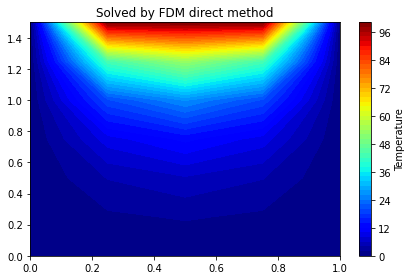

In [4]:
scipy_x = spsolve(A, true_b)
T = get_temperature(scipy_x, N, BC)

# plot
x = np.linspace(0, L['x'], N['x']+2)
y = np.linspace(0, L['y'], N['y']+2)
X, Y = np.meshgrid(x, y)
colorinterpolation = 50
colourMap = plt.cm.jet
plt.contourf(X, Y, T, colorinterpolation, cmap=colourMap)
plt.colorbar(label='Temperature')
plt.title('Solved by FDM direct method')
plt.tight_layout()
plt.show()

## Solve A_discrete*q=b problem as BQM optimization through simulated annealing or quantum annealing

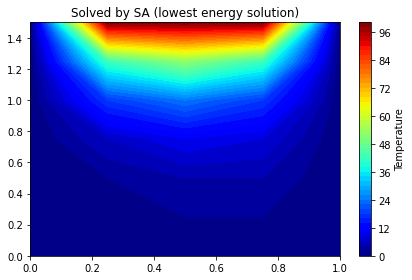

In [5]:
Q = bl_lstsq.get_qubo(A_discrete, true_b.toarray(), eq_scaling_val=eq_scaling_val)
if sampler_type == 'QA':
    try:
        sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
        _sampler_args = {}
        if 'num_reads' in sampler.parameters:
            _sampler_args['num_reads'] = num_reads
        if 'answer_mode' in sampler.parameters:
            _sampler_args['answer_mode'] = 'raw'
        sampleset = sampler.sample_qubo(Q, **_sampler_args)
    except ValueError:
        warnings.warn('Cannot access QPU, use \
                        SimulatedAnnealingSampler instead.')
        sampler = SimulatedAnnealingSampler()
        sampleset = sampler.sample_qubo(Q, num_reads=num_reads)
elif sampler_type == 'SA':
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(Q, num_reads=num_reads)
else:
    raise(ValueError("The sampler_type is wrong, \
                        please enter 'SA' or 'QA'"))

num_q_entry = A_discrete.shape[1]
sampleset_pd_agg = sampleset.aggregate().to_pandas_dataframe()
lowest_q = sampleset_pd_agg.sort_values('energy').iloc[0, :num_q_entry].values
lowest_x = Binary2Float.to_fixed_point(lowest_q, bit_value)
T = get_temperature(lowest_x, N, BC)

# plot
plt.contourf(X, Y, T, colorinterpolation, cmap=colourMap)
plt.colorbar(label='Temperature')
plt.title('Solved by SA (lowest energy solution)')
plt.tight_layout()
plt.show()